In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import pandas

import glob
import os
import json

import sncosmo
import piscola as pisco
from astropy.table import Table


#sns.set(font_scale=1.5, context='paper', style='white')
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Gentium"
plt.rcParams['mathtext.fontset'] = "cm"

In [2]:
def piscola2sncosmo(sn, zpsys='ab'): 
    '''Converts a PISCOLA object to data that can be read by sncosmo'''
    
    sn_df = pd.DataFrame({col:[] for col in sn.data[sn.bands[0]].keys()}) 

    for band in sn.bands:
        band_df = pd.DataFrame(sn.data[band]) 
        band_df['band'] = band
        band_df['zpsys'] = zpsys
        sn_df = pd.concat([sn_df, band_df], sort=False)

    sn_table = Table.from_pandas(sn_df)  
    return sn_table

def plot_salt2_fits(name, use_salt2_params=True):
    
    # load salt2 parameters
    sample_file = '../analysis/test_files//Pantheon/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'
    sample_df = pd.read_csv(sample_file, delim_whitespace=True, comment='#')
    
    assert name in sample_df.CID.values, f'SN {name} is not in found in the pantheon file: {os.path.basename(sample_file)}'
    
    sn_vals = sample_df[sample_df.CID==name]
    
    # load SN photometry
    sn_file = [file for file in glob.glob('../analysis/data_pantheon/*') if name in file][0]
    df = pd.read_csv(sn_file, delim_whitespace=True, skiprows=2)
    
    pisco_name = os.path.basename(sn_file).split('.')[0]
    sn = pisco.call_sn(pisco_name, directory='../analysis/data_pantheon') 
    
    # select calibration file
    ppath = pisco.__path__[0]
    if sn.data[sn.bands[0]]['mag_sys'].lower()=='bd17':
        zps_file = os.path.join(ppath, 'standards/bd17_sys_zps.dat')
        zpsys = 'bd17'
    elif sn.data[sn.bands[0]]['mag_sys'].lower()=='ab':
        zps_file = os.path.join(ppath, 'standards/ab_sys_zps.dat')
        zpsys = 'ab'
    zp_dict = {} 

    # add filters, zps and magnitude system to sncosmo registry
    for band in sn.bands:
        bandpass = sncosmo.Bandpass(sn.filters[band]['wave'], sn.filters[band]['transmission'], name=band) 
        sncosmo.register(bandpass, band, force=True)

        with open(zps_file, 'r') as zpsys_file:
            zp = [line.split()[1] for line in zpsys_file if band in line.split()][0]
            zp = eval(zp)
            zp_dict.update({band:(zpsys, zp)})

    magsys = sncosmo.CompositeMagSystem(bands=zp_dict, name='pantheon')    
    sncosmo.registry.register(magsys, force=True)
    
    # add the SN parameters to the sncosmo model (salt2)
    dust = sncosmo.F99Dust()
    dust.set(ebv=sn_vals.MWEBV.values[0]) 

    model = sncosmo.Model(source='salt2', effects=[dust], effect_names=['mwebv'], effect_frames=['obs'])
    data = piscola2sncosmo(sn, zpsys)
    
    if use_salt2_params:
        # NOTE - SNANA SALT2 implementation has a 0.27 mag offset from sncosmo.
        # this doesn't matter at all for most things like cosmology analyses,
        # but certainly matters for making plots
        model.set(z=sn_vals.zCMB.values, 
                  t0=sn_vals.PKMJD.values,
                  x1=sn_vals.x1.values, 
                  c=sn_vals.c.values, 
                  x0=sn_vals.x0.values*10**(-0.4*(0.27))
                 ) 
        result, fitted_model = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'c'], )
    else:
        #model.set(z=sn_vals.zCMB.values)
        model = sncosmo.Model(source='salt2')
        result, fitted_model = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'c'], bounds={'z':(0.3, 0.7)})

    

    ##########################################
    # plotting
    N = len(sn.bands)
    h = 3
    v = math.ceil(N/ h)

    fig = plt.figure(figsize=(20, 4*v))
    gs = gridspec.GridSpec(v , h)
    
    fig.text(0.5, 0.90, f'SN {name} (z = {sn_vals.zCMB.values[0]:.4f})', ha='center', fontsize=20, family='serif')
    fig.text(0.5, 0.05, 'Phase with respect to B-band peak', ha='center', fontsize=18, family='serif')
    fig.text(0.04, 0.5, 'Flux (zp = 27.5)', va='center', rotation='vertical', fontsize=18, family='serif')

    #mjd = np.arange(sn_vals.PKMJD.values-10, sn_vals.PKMJD.values+40, 1)
    mjd = np.arange(sn_vals.PKMJD.values-20, sn_vals.PKMJD.values+50, 1)
    phases = mjd - sn_vals.PKMJD.values
    for i, band in enumerate(sn.bands):
        j = math.ceil(i % h)
        k =i // h
        ax = plt.subplot(gs[k,j])

        # plot the model / careful about zpsys!
        try:
            salt2flux = fitted_model.bandflux(band, mjd, zp=27.5, zpsys=zpsys)
            #salt2flux = fitted_model.bandflux(band, mjd, zp=sn.data[band]['zp'], zpsys=zpsys)
            ax.plot(phases, salt2flux)
        except:
            print(f'band {band} is outside the spectral range of salt2')

        # plot the data
        band_df = df[df.band==band]
        time, flux, err = band_df.time, band_df.flux, band_df.flux_err
        phase = time - sn_vals.PKMJD.values
        ax.errorbar(phase, flux, yerr=err, fmt='.', label=band)
        ax.axvline(0.0, color='k', ls='--')
        ax.set_xlim(phases.min()-10, phases.max()+10)
        ax.legend(fontsize=14)    

    plt.show()

In [3]:
plot_salt2_fits('2004eo', False)

FileNotFoundError: [Errno 2] File b'../analysis/test_files//Pantheon/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres' does not exist: b'../analysis/test_files//Pantheon/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'

In [8]:
sn = pisco.call_sn('sn2004eo', directory='data_pantheon')
zpsys = 'bd178'

sn_table = piscola2sncosmo(sn, zpsys)
model = sncosmo.Model(source='salt2')

model.set(z=sn.z)
# run the fit
result, fitted_model = sncosmo.fit_lc(
    sn_table, model,
    #['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    ['t0', 'x0', 'x1', 'c']
    #bounds={'z':(0.01, 0.02)}
)  # bounds on parameters (if any)

ValueError: sn2004eo was not a valid SN name or file.

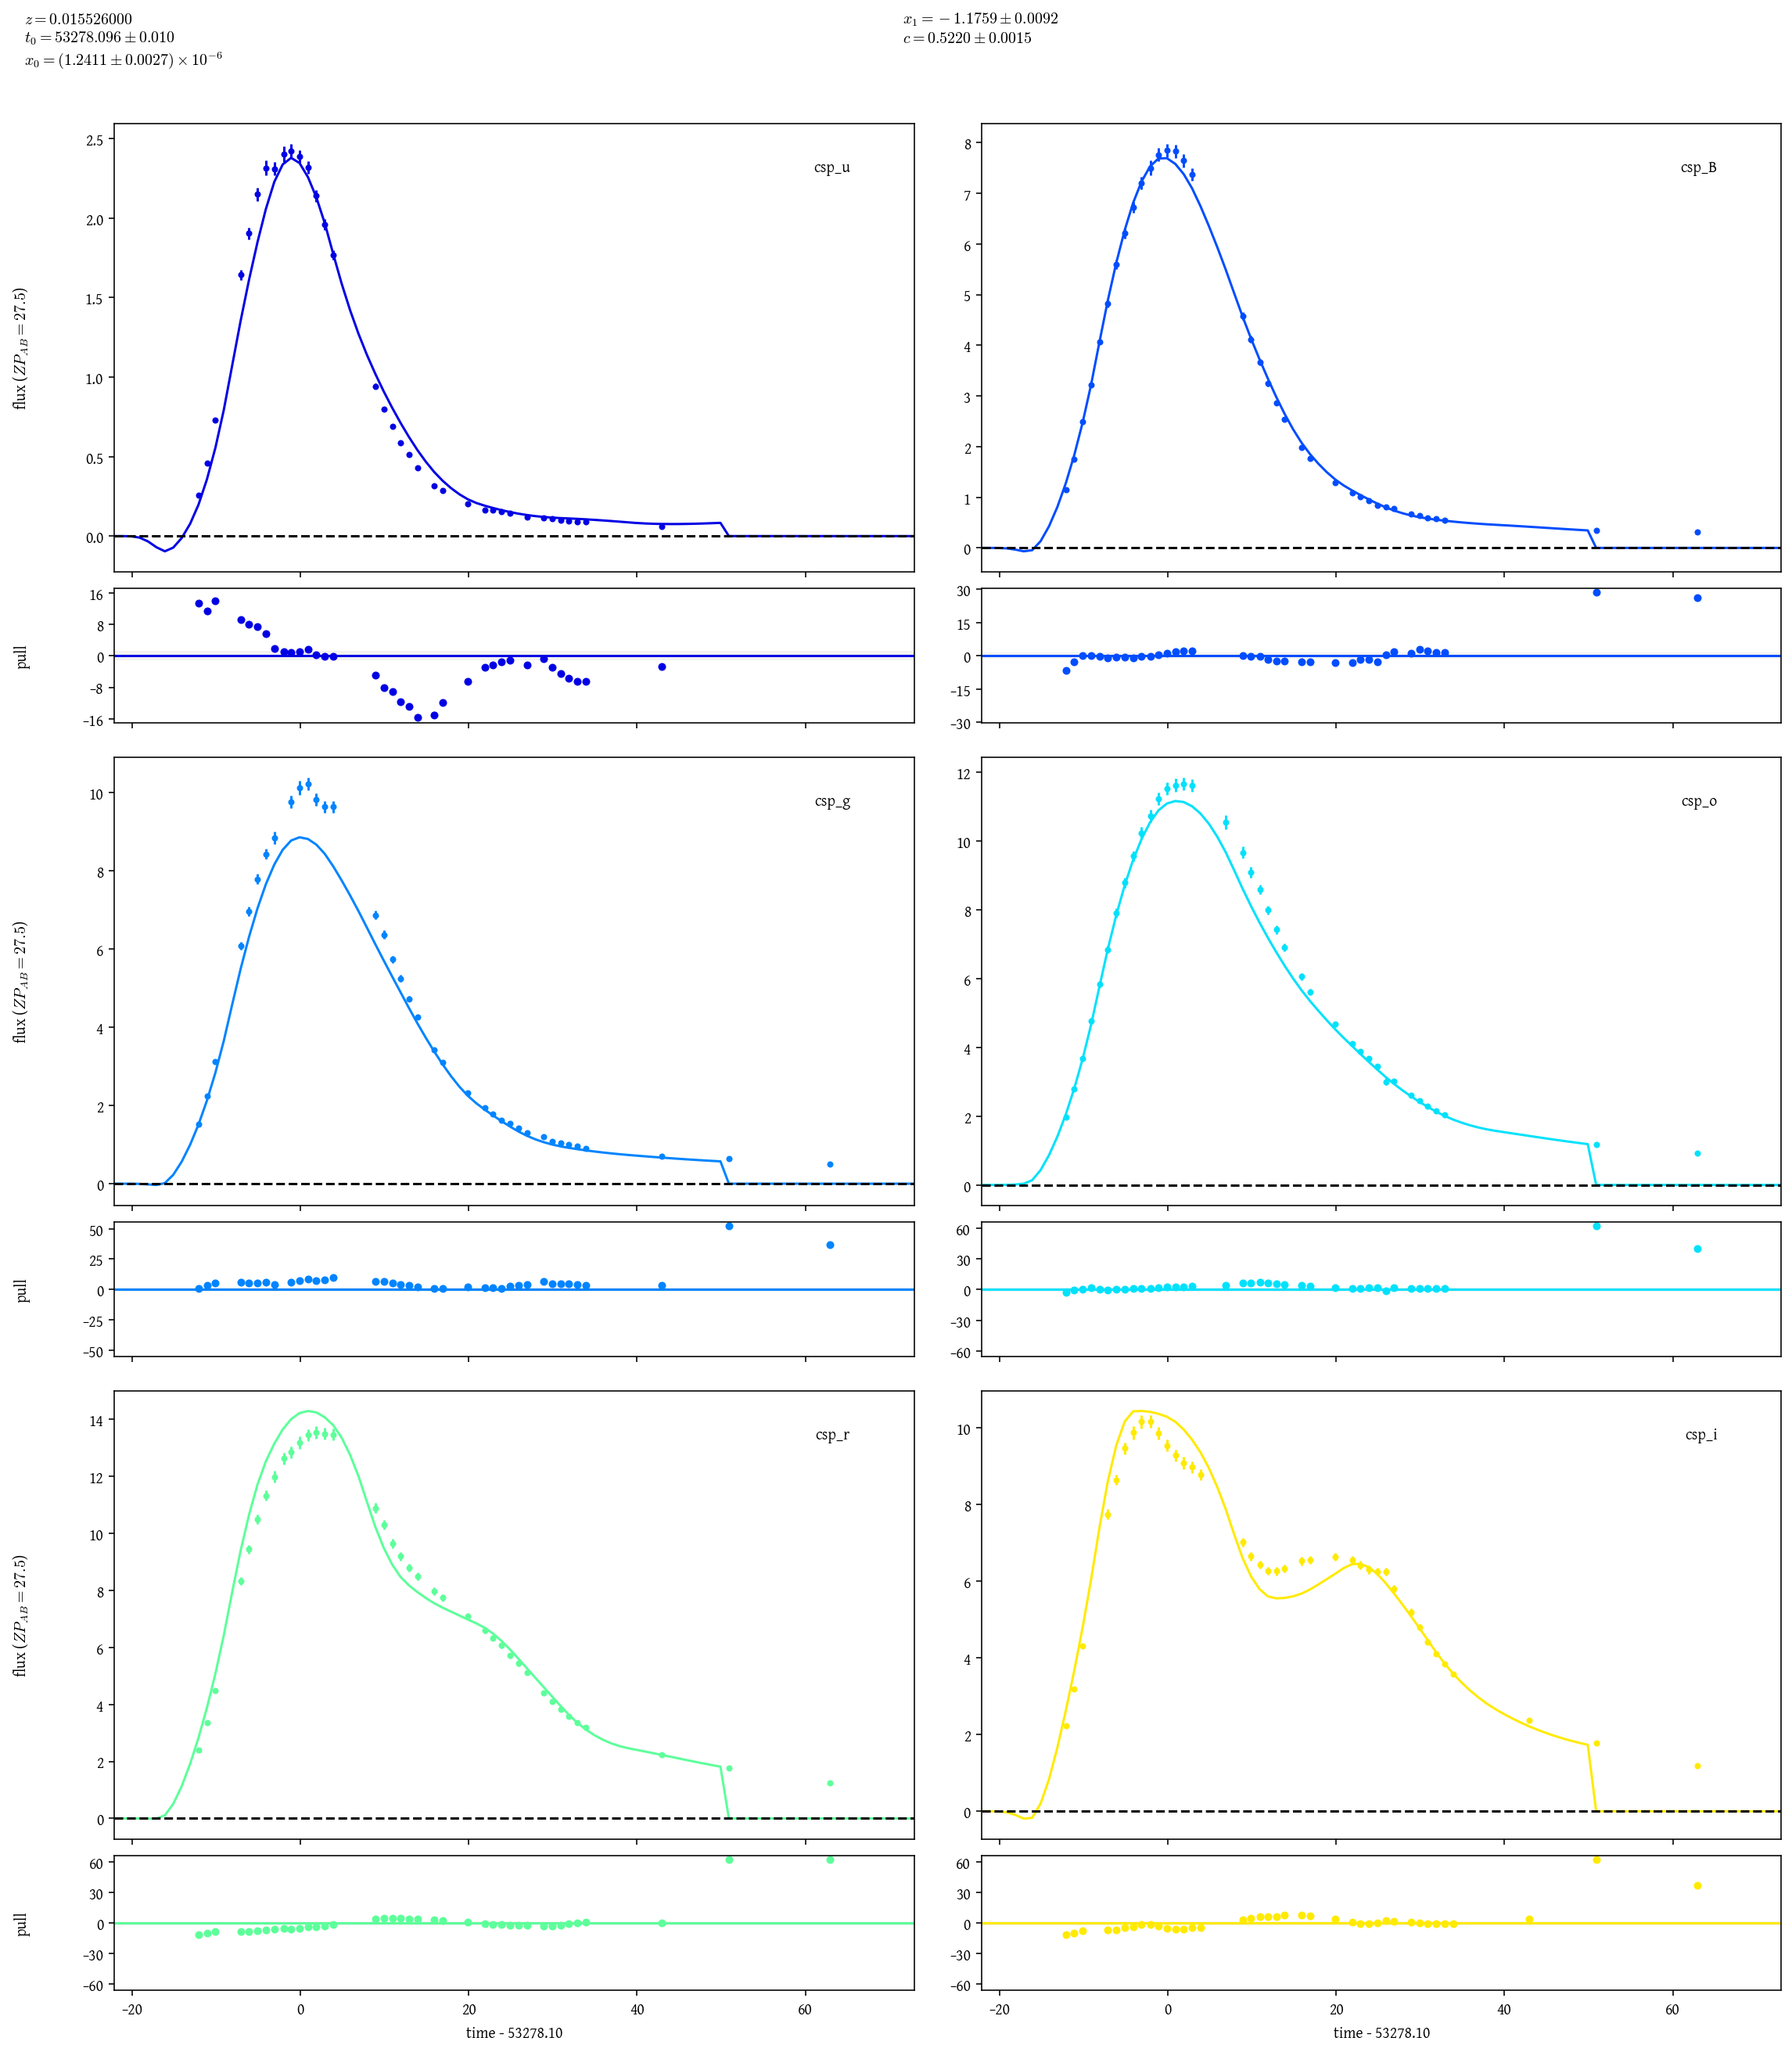

In [127]:
sncosmo.plot_lc(sn_table, model=fitted_model, errors=result.errors, xfigsize=16, zp=27.5);